In [1]:
import os

# List all files in the dataset directory
base_path = '/kaggle/input/cleaneddata/cleaned_train_copy.csv'

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.preprocessing import label_binarize

dataset = pd.read_csv(base_path)
dataset.head(5)

,id,Basic_Demos-Age,Basic_Demos-Sex,age_group,CGAS_Score,Physical-BMI,BIA_Activity_Level,Fitness_Combined_Score,Physical_Composite_Index,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,5,0,Child,51.000000,16.877316,2.0,0.200000,0.184805,64.4,3.0,2.0
1,000fd460,9,0,Early Teen,65.156829,14.035590,2.0,0.400000,0.178587,64.0,0.0,0.0
2,00105258,10,1,Early Teen,65.156829,19.131648,3.0,0.583126,0.193319,54.0,2.0,0.0
3,00115b9f,9,0,Early Teen,71.000000,18.292347,3.0,0.400000,0.190185,45.0,0.0,1.0
4,001f3379,13,1,Teen,50.000000,22.279952,2.0,0.400000,0.217322,56.0,0.0,1.0


In [2]:
dataset.drop(['age_group','id'], axis=1, inplace=True)

In [3]:
X, y = dataset.drop(columns=['sii']), dataset['sii']  # Replace 'sii' with target column
feature_variances = np.var(X, axis=0)
print(f"Feature Variances:\n{feature_variances}\n")

Feature Variances:
Basic_Demos-Age                            11.714467
Basic_Demos-Sex                             0.231631
CGAS_Score                                118.722679
Physical-BMI                               22.175212
BIA_Activity_Level                          1.063243
Fitness_Combined_Score                      0.058972
Physical_Composite_Index                    0.000269
SDS-SDS_Total_T                           159.711113
PreInt_EduHx-computerinternet_hoursday      1.158760
dtype: float64



High Variance Features:

SDS-SDS_Total_T (159.71): This feature has the highest variance and contributes significantly to the dataset's variability.
CGAS_Score (118.72): Another highly variable feature that might be essential for modeling.
Physical-BMI (22.18): Moderate variance, still meaningful.
Moderate Variance Features:

Basic_Demos-Age (11.71): Captures decent variability, likely important.
PreInt_EduHx-computerinternet_hoursday (1.16): Lower but non-negligible variance.
BIA_Activity_Level (1.06): Just above the threshold for near-zero variance.
Low Variance Features:

Basic_Demos-Sex (0.23): Minimal variability; likely a categorical or binary feature.
Fitness_Combined_Score (0.059): Very low variance; possibly not useful.
Physical_Composite_Index (0.00027): Extremely low variance, likely constant or nearly constant.

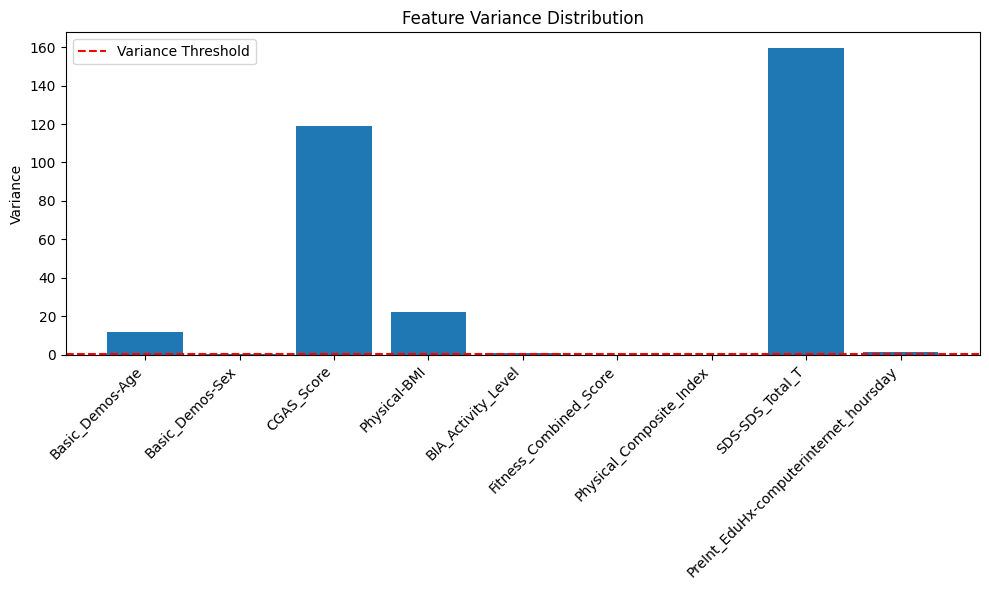

In [4]:

variance_threshold = 0.1

plt.figure(figsize=(10, 6))
plt.bar(feature_variances.index, feature_variances.values)
plt.axhline(y=variance_threshold, color='r', linestyle='--', label="Variance Threshold")
plt.xticks(rotation=45, ha="right")
plt.title("Feature Variance Distribution")
plt.ylabel("Variance")
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# Get the column names of features with variance above the threshold
selected_features = feature_variances[feature_variances > 0.1].index

# Filter the data for high-variance features
X_high_variance = X[selected_features]  # Assumes X is a DataFrame with named columns

print(f"Selected High Variance Features:\n{selected_features}\n")
print(f"Reduced Feature Set Shape: {X_high_variance.shape}")


Selected High Variance Features:
Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS_Score', 'Physical-BMI',
       'BIA_Activity_Level', 'SDS-SDS_Total_T',
       'PreInt_EduHx-computerinternet_hoursday'],
      dtype='object')

Reduced Feature Set Shape: (2730, 7)


In [6]:
# Pairwise distances and PCA
from sklearn.metrics import pairwise_distances

pairwise_dist = pairwise_distances(X_high_variance)
print(f"Pairwise Distances:\n{pairwise_dist}\n")

Pairwise Distances:
[[ 0.         15.28565371 18.48398827 ... 18.91097766 22.66256337
  27.51913487]
 [15.28565371  0.         11.53125358 ... 15.68461695 15.36004949
  18.34925633]
 [18.48398827 11.53125358  0.         ...  7.82695906 23.43968933
  11.48946119]
 ...
 [18.91097766 15.68461695  7.82695906 ...  0.         28.71927305
  11.27069381]
 [22.66256337 15.36004949 23.43968933 ... 28.71927305  0.
  31.58707266]
 [27.51913487 18.34925633 11.48946119 ... 11.27069381 31.58707266
   0.        ]]



In [7]:
# PCA Analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_high_variance)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio (PCA): {explained_variance}")
print(f"Cumulative Explained Variance: {np.cumsum(explained_variance)}")

Explained Variance Ratio (PCA): [0.26551433 0.16682021 0.15106567]
Cumulative Explained Variance: [0.26551433 0.43233453 0.5834002 ]


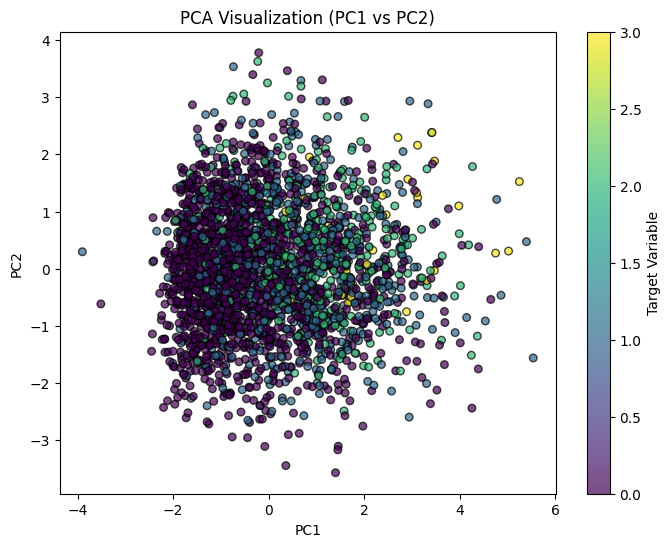

In [8]:
# Visualize PCA components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", s=30, edgecolor="k", alpha=0.7)
plt.title("PCA Visualization (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Target Variable")
plt.show()

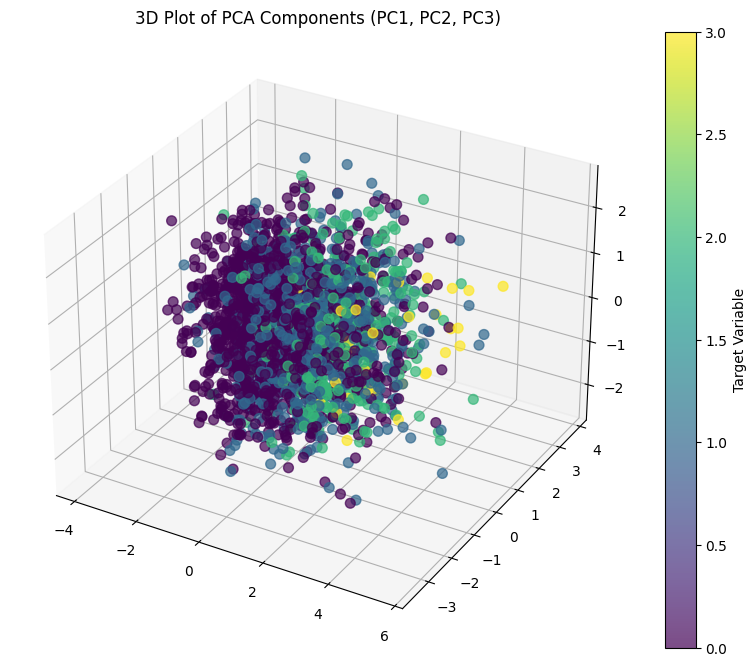

In [9]:
# 3D Plot of PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap="viridis", s=50, alpha=0.7)
plt.title("3D Plot of PCA Components (PC1, PC2, PC3)")
plt.colorbar(sc, label="Target Variable")
plt.show()

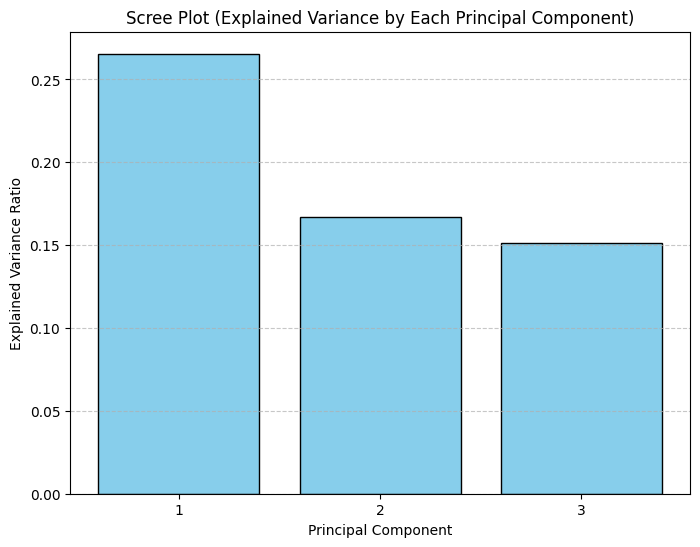

In [10]:
# Scree Plot for individual explained variance
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, color="skyblue", edgecolor="black")
plt.title("Scree Plot (Explained Variance by Each Principal Component)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


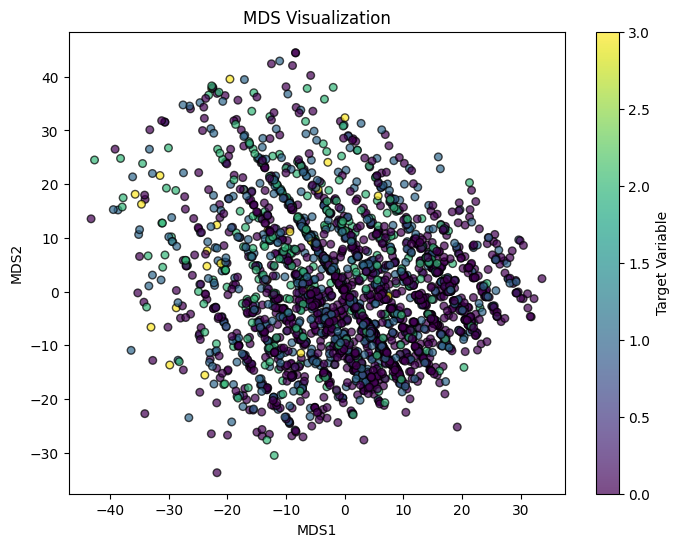

In [11]:
# Other Dimensionality Reduction Techniques
# MDS
from sklearn.manifold import MDS, TSNE, Isomap
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X_high_variance)

plt.figure(figsize=(8, 6))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y, cmap="viridis", s=30, edgecolor="k", alpha=0.7)
plt.title("MDS Visualization")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.colorbar(label="Target Variable")
plt.show()

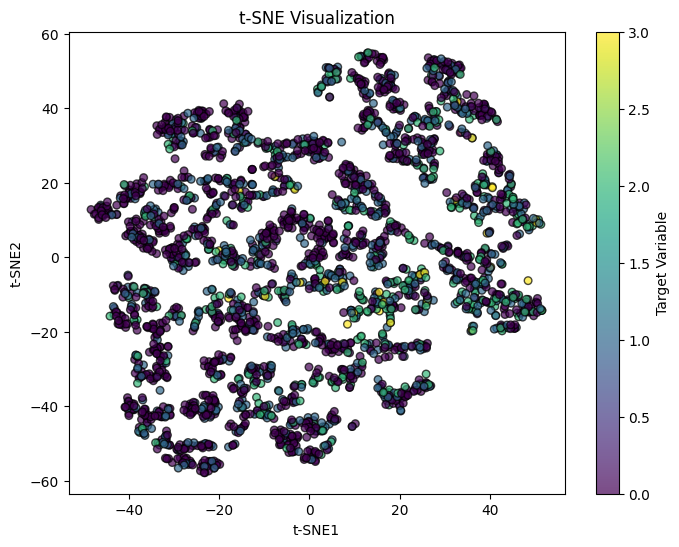

In [12]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_high_variance)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="viridis", s=30, edgecolor="k", alpha=0.7)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.colorbar(label="Target Variable")
plt.show()

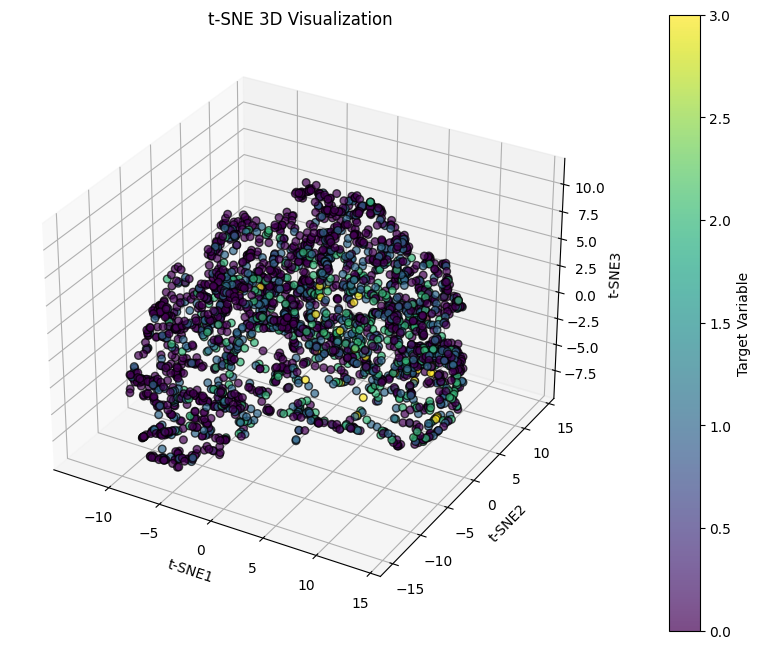

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# t-SNE with 3 components
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_3d = tsne.fit_transform(X_high_variance)

# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], 
    c=y, cmap="viridis", s=30, edgecolor="k", alpha=0.7
)

# Titles and labels
ax.set_title("t-SNE 3D Visualization")
ax.set_xlabel("t-SNE1")
ax.set_ylabel("t-SNE2")
ax.set_zlabel("t-SNE3")

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Target Variable")
plt.show()


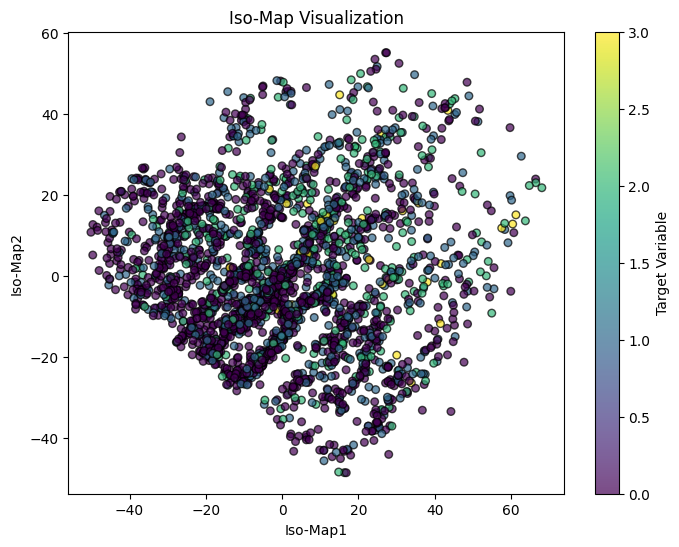

In [14]:
# Iso-map
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X_high_variance)

plt.figure(figsize=(8, 6))
plt.scatter(X_isomap[:, 0], X_isomap[:, 1], c=y, cmap="viridis", s=30, edgecolor="k", alpha=0.7)
plt.title("Iso-Map Visualization")
plt.xlabel("Iso-Map1")
plt.ylabel("Iso-Map2")
plt.colorbar(label="Target Variable")
plt.show()

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
# Naive Bayes Baseline
X_train, X_test, y_train, y_test = train_test_split(X_high_variance, y, test_size=0.3, random_state=42, stratify=y)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.87      0.76       477
         1.0       0.36      0.20      0.26       219
         2.0       0.34      0.20      0.25       113
         3.0       0.19      0.30      0.23        10

    accuracy                           0.59       819
   macro avg       0.39      0.39      0.38       819
weighted avg       0.54      0.59      0.55       819



The results indicate some improvement in classifying the minority classes, but the overall performance still reflects challenges in dealing with the class imbalance, especially for classes 1.0, 2.0, and 3.0

Class 0.0 (Majority Class):
Good precision, recall, and F1-score, as expected, since it's overrepresented.
Class 1.0 and 2.0 (Minority Classes):
Precision and recall are low, indicating difficulty in distinguishing these classes.
Class 3.0 (Highly Minority):
Recall is high but precision is very poor, likely due to oversampling by SMOTE leading to overfitting for this class.

Recommendations and Updates
Advanced Resampling Strategy:
Instead of plain SMOTE, use SMOTE-Tomek or ADASYN, which refine synthetic sample generation to reduce noise.
Hyperparameter Tuning:
Adjust SVM parameters (C, gamma, kernel) using GridSearchCV or RandomizedSearchCV to find optimal values.
Custom Kernel:
Experiment with a polynomial or sigmoid kernel to improve separability.
Ensemble Techniques:
Combine SVM with other classifiers (e.g., Random Forest, Gradient Boosting) using an ensemble method like voting or stacking.
Evaluation Metrics:
Visualize precision-recall and ROC curves per class.
Data Preprocessing:
Apply feature selection or engineering to better separate the minority classes.
Class-Specific Threshold Tuning:
Adjust decision thresholds for each class based on ROC curves to balance precision and recall.

In [16]:
X, y = dataset.drop(columns=['sii']), dataset['sii']  # Replace 'sii' with target column
scaler = StandardScaler()
X_std = scaler.fit_transform(X_high_variance)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42, stratify=y)
# Step 1: Advanced Resampling with SMOTE-Tomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Step 2: Hyperparameter Tuning for SVM
param_grid = {
    'C': [1],
    'gamma': [0.7],
    'kernel': ['rbf']
}
grid_search = GridSearchCV(SVC(probability=True, class_weight='balanced', random_state=42),
                           param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)



Best Parameters: {'C': 1, 'gamma': 0.7, 'kernel': 'rbf'}


In [17]:
# Train SVM with best parameters
svm_model = SVC(**best_params, probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_resampled, y_resampled)



SVC(C=1, class_weight='balanced', gamma=0.7, probability=True, random_state=42)

In [18]:
# Step 3: Analyze Support Vectors
support_vectors = svm_model.support_vectors_
num_support_vectors = len(support_vectors)
support_vector_indices = svm_model.support_
print(f"Number of Support Vectors: {num_support_vectors}")
print(f"Support Vector Indices: {support_vector_indices}")

Number of Support Vectors: 3216
Support Vector Indices: [   1    3    4 ... 4908 4912 4916]


In [19]:
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)

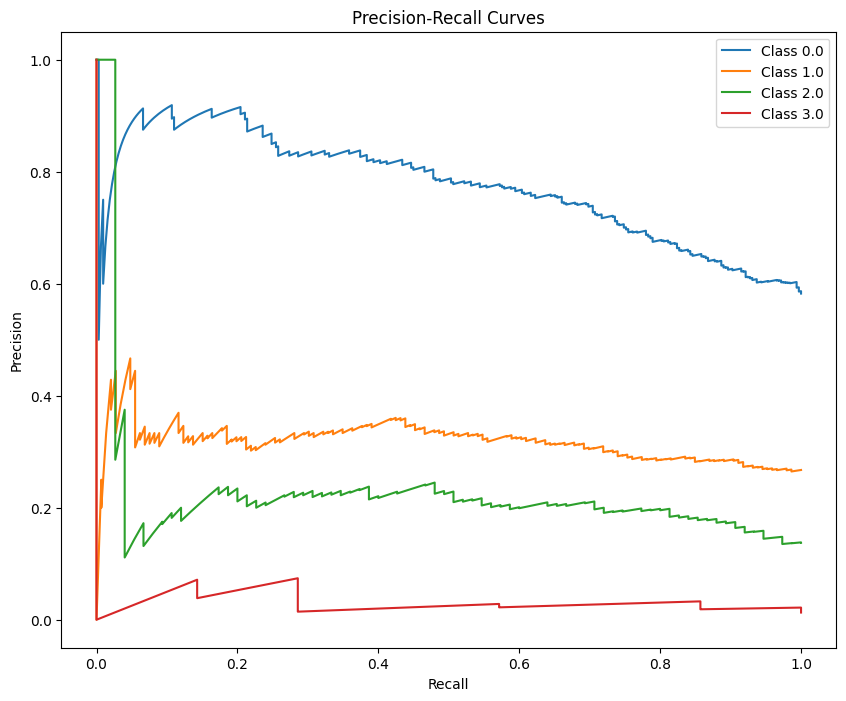

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [20]:
# Evaluate Precision-Recall and ROC Curves for each class
plt.figure(figsize=(10, 8))
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
for i, class_label in enumerate(np.unique(y)):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {class_label}")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))


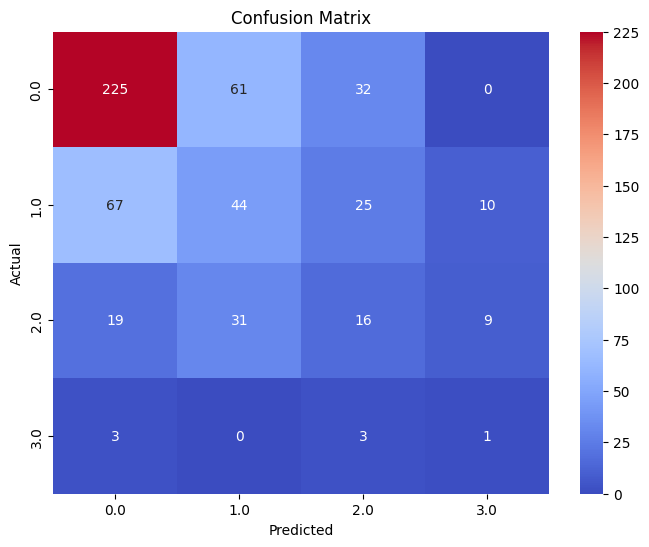

In [21]:
# Updated Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="coolwarm", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


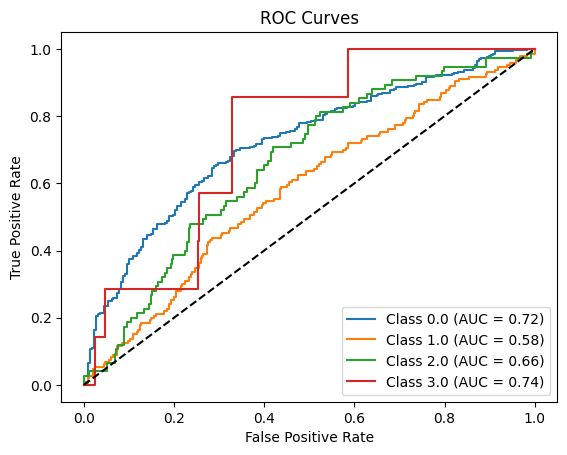

In [22]:
roc_auc_scores = roc_auc_score(y_test_binarized, y_prob, average=None)
for i, class_label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc_scores[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



In [23]:
# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5238095238095238
Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.71      0.71       318
         1.0       0.32      0.30      0.31       146
         2.0       0.21      0.21      0.21        75
         3.0       0.05      0.14      0.07         7

    accuracy                           0.52       546
   macro avg       0.33      0.34      0.33       546
weighted avg       0.53      0.52      0.53       546

Confusion Matrix:
 [[225  61  32   0]
 [ 67  44  25  10]
 [ 19  31  16   9]
 [  3   0   3   1]]
